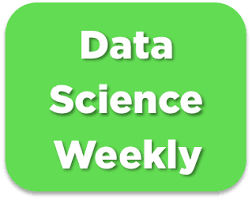

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
#pio.templates.default = "jedha"
#pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
#from IPython.display import display

# Read file with labels

In [ ]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [ ]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [ ]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [ ]:
data.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [ ]:
#check if there is any null value. No null is found.
data.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [ ]:
data.describe()

,age,new_user,total_pages_visited,converted
count,284580.000000,284580.000000,284580.000000,284580.000000
mean,30.564203,0.685452,4.873252,0.032258
std,8.266789,0.464336,3.341995,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [ ]:
#unique values

print("Unique values of country :", data['country'].unique())

print("Unique values of new_user :",data['new_user'].unique())

print("Unique values of source :",data['source'].unique())

print("Unique values of converted :",data['converted'].unique())

Unique values of country : ['China' 'UK' 'Germany' 'US']
Unique values of new_user : [1 0]
Unique values of source : ['Direct' 'Ads' 'Seo']
Unique values of converted : [0 1]


In [ ]:
data.age.unique()

array([ 22,  21,  20,  23,  28,  29,  30,  38,  26,  31,  18,  27,  24,
        37,  42,  33,  45,  32,  39,  17,  34,  40,  25,  36,  62,  44,
        55,  41,  35,  49,  19,  43,  50,  47,  53,  52,  46,  48,  58,
        51,  57,  56,  61,  59,  60,  54,  67,  63, 111,  65,  64,  66,
        72,  68,  69,  70,  73,  79, 123,  77])

In [ ]:
# You can delete 2 records which are more than 80 years old

#data = data[data['age']<80]
#data.shape


In [ ]:
data.groupby('converted').mean()

<ipython-input-77-79c0ffecaefb>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby('converted').mean()


,age,new_user,total_pages_visited
converted,,,
0,30.697422,0.698348,4.550359
1,26.567647,0.298584,14.560022


In [ ]:
users = pd.Series(data.groupby('country').size(), name = 'total_users')
users

country
China       69122
Germany     11693
UK          43641
US         160124
Name: total_users, dtype: int64

<Axes: xlabel='source'>

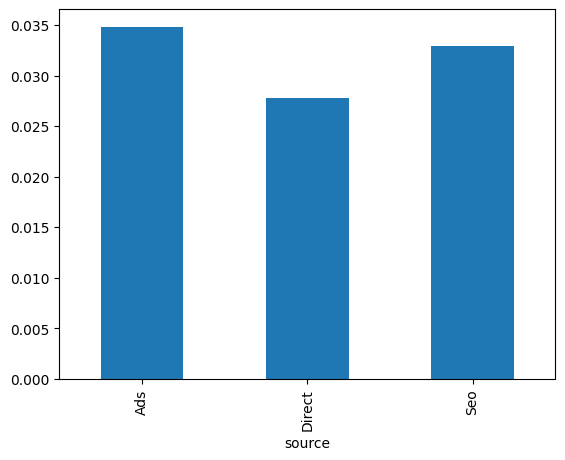

In [ ]:
data_source = data.groupby('source').converted.mean()
data_source.plot(kind='bar')

<Axes: xlabel='total_pages_visited'>

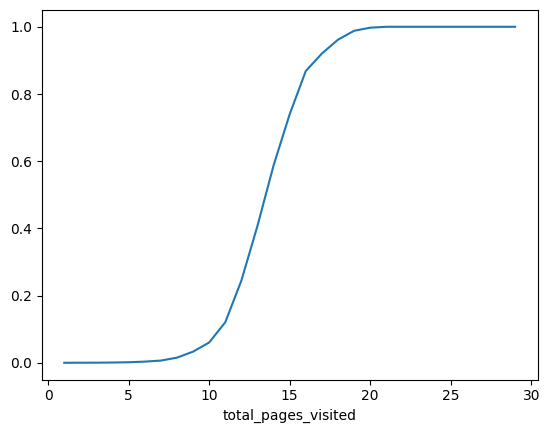

In [ ]:
data_page = data.groupby('total_pages_visited').converted.mean()
data_page.plot()

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [ ]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "converted"

X = data.drop(target_variable, axis = 1)
Y = data.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   country  age  new_user  source  total_pages_visited
0    China   22         1  Direct                    2
1       UK   21         1     Ads                    3
2  Germany   20         0     Seo                   14
3       US   23         1     Seo                    3
4       US   28         1  Direct                    3


In [ ]:
# Divide dataset Train set & Test set
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [ ]:
#Convert pandas DataFrames to numpy arrays before using scikit-learn
#print("Convert pandas DataFrames to numpy arrays...")
#X_train = X_train.values
#X_test = X_test.values
#Y_train = Y_train.values
#Y_test = Y_test.values
#print("...Done")

#print(X_train[0:5,:])
#print(X_test[0:2,:])
#print()
#print(Y_train[0:5])
#print(Y_test[0:2])

In [ ]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source']


<ipython-input-84-0f0a515c43b5>:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i,t in X.dtypes.iteritems():


In [ ]:
print (X.shape)
print (Y.shape)

(284580, 5)
(284580,)


In [ ]:
# Create pipeline for numeric features
numeric_transformer = SimpleImputer(strategy='mean') # missing values will be replaced by columns' mean


In [ ]:
# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first') # no missing values in categorical data, so we only need the OHE

In [ ]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Training pipeline

In [ ]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()


Performing preprocessings on train set...
       country  age  new_user source  total_pages_visited
108451      US   26         0    Seo                    8
169637      US   25         1    Ads                   10
113084      US   18         1    Ads                    8
22056       US   34         1    Seo                    2
5484     China   21         1    Seo                    1
...Done.
[[26.  0.  8.  0.  0.  1.  0.  1.]
 [25.  1. 10.  0.  0.  1.  0.  0.]
 [18.  1.  8.  0.  0.  1.  0.  0.]
 [34.  1.  2.  0.  0.  1.  0.  1.]
 [21.  1.  1.  0.  0.  0.  0.  1.]]



In [ ]:
# Train model
print("Train model...")
classifier = RandomForestClassifier(random_state =0,max_depth= 8, min_samples_leaf= 5, min_samples_split= 4, n_estimators= 2) #
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [ ]:
#from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier# Perform grid search

#print("Grid search...")
#classifier = RandomForestClassifier()

# Grid of values to be tested
#params = {
 #   'max_depth': [2, 4, 6, 8, 10],
  #  'min_samples_leaf': [1, 2, 5],
   # 'min_samples_split': [2, 4, 8],
   # 'n_estimators': [10, 20, 40, 60, 80, 100]
#}
#gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
#gridsearch.fit(X_train, Y_train)
#print("...Done.")
#print("Best hyperparameters : ", gridsearch.best_params_)
#print("Best validation accuracy : ", gridsearch.best_score_)

## Test pipeline

In [ ]:
# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()


Performing preprocessings on test set...
        country  age  new_user source  total_pages_visited
149371       US   20         1    Ads                    7
221325       US   31         1    Seo                    5
14016        US   28         0    Seo                    4
257982  Germany   25         1    Ads                    4
59983        US   44         0    Ads                    7
...Done.
[[20.  1.  7.  0.  0.  1.  0.  0.]
 [31.  1.  5.  0.  0.  1.  0.  1.]
 [28.  0.  4.  0.  0.  1.  0.  1.]
 [25.  1.  4.  1.  0.  0.  0.  0.]
 [44.  0.  7.  0.  0.  1.  0.  0.]]



In [ ]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [ ]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.758973454449246
f1-score on test set :  0.742476267420723


In [ ]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[219485    849]
 [  2264   5066]]

Confusion matrix on test set : 
[[54857   209]
 [  593  1257]]



**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)



LogisticRegression(max_iter=1000)

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

Prediction set (without labels) : (31620, 5)


In [ ]:
# Warning : check consistency of features_list (must be the same than the features
# used by your best classifier)
features_list = ['age','new_user','total_pages_visited','country', 'source']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
#print("Convert pandas DataFrames to numpy arrays...")
#X_without_labels = X_without_labels.values
#print("...Done")

#print(X_without_labels[0:5,:])

In [ ]:
X_without_labels.head()

,age,new_user,total_pages_visited,country,source
0,28,0,16,UK,Seo
1,22,1,5,UK,Direct
2,32,1,1,China,Seo
3,32,1,6,US,Ads
4,25,0,3,China,Seo


In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

...Done
[[28.  0. 16.  0.  1.  0.  0.  1.]
 [22.  1.  5.  0.  1.  0.  1.  0.]
 [32.  1.  1.  0.  0.  0.  0.  1.]
 [32.  1.  6.  0.  0.  1.  0.  0.]
 [25.  0.  3.  0.  0.  0.  0.  1.]]


In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_YVI-LR1.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**